In [20]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
import utils
import os
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import time
import LSE_net
from torch import optim
import importlib

In [21]:
seed=41;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
print("Running on: " , device)

Running on:  cpu


num_drones = 100	num_facilities = 100	dim = 2
Data Loaded.


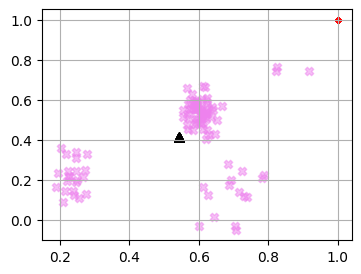

In [22]:
# UAV FLPO MetaData
num_drones = 100
n_drone_clusters = 5
drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
num_facilities = 100
dim_ = 2
print(f'num_drones = {num_drones}\tnum_facilities = {num_facilities}\tdim = {dim_}')

# Assign start location to each drone
drone_cnt = 0
for i in range(n_drone_clusters):
    if i == n_drone_clusters-1:
        n_drones = int(num_drones - drone_cnt)
    else:
        n_drones = int(drone_cluster_split[i] * (num_drones+1))
        drone_cnt += n_drones

    drone_cluster_mean = torch.rand(1, dim_).repeat(n_drones,1).unsqueeze(1).to(device)
    drone_cluster_std = ((0.02 - 0.08) * torch.rand(1,dim_) + 0.08).repeat(n_drones,1).unsqueeze(1).to(device)
    drone_cluster_START_locs = torch.normal(mean=drone_cluster_mean, std=drone_cluster_std)
    if i == 0:
        START_locs = drone_cluster_START_locs
    else:
        START_locs = torch.cat((START_locs, drone_cluster_START_locs), axis=0)

START_locs.shape

# Assign destination location to each drone
END_locs = torch.ones((num_drones, 1, dim_), requires_grad=False, device=device) #torch.rand(num_drones, 1, dim_, requires_grad=False, device=device)

# Create the data tensor
F_base = torch.mean(START_locs, dim=0).repeat(num_facilities, 1).unsqueeze(0).requires_grad_().to(device)
F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
data = torch.cat((START_locs, F_locs, END_locs), dim=1)  # shape: (Nd, Nf+2, D)
print("Data Loaded.")

# plot the data
def plot_UAV_FLPO(drone_START, drone_END, Facilities, figuresize=(6,5)):
    start_locs = drone_START.squeeze(1).cpu().numpy()
    end_locs = drone_END.squeeze(1).cpu().numpy()
    f_locs = Facilities.squeeze(0).detach().cpu().numpy()

    plt.figure(figsize=figuresize)
    plt.scatter(start_locs[:,0], start_locs[:,1], color='violet', marker='X', alpha=0.5)
    plt.scatter(end_locs[:,0], end_locs[:,1], color='red', marker='.')
    plt.scatter(f_locs[:,0], f_locs[:,1], color='black', marker='^')
    plt.grid()
    plt.show()

plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))

### Load the VRP NET Module

In [23]:
hidden_dim = 32
num_layers_enc = 1
num_layers_dec = 1
num_heads = 8
torch.cuda.empty_cache()
vrp_net = VRPNet_L(dim_, hidden_dim, device, num_layers_enc, num_layers_dec, num_heads)
if torch.cuda.is_available():
    vrp_net.load_state_dict(torch.load('Saved models/POMO2025_04_12 00_54_260.6350972652435303best_model.pth',weights_only=True))
else:
    vrp_net.load_state_dict(torch.load('Saved models/POMO2025_04_12 00_54_260.6350972652435303best_model.pth',weights_only=False, map_location=torch.device('cpu')))
vrp_net.eval()

# for param in vrp_net.parameters():
#     param.requires_grad = False
print('VRP NET loaded on: ',vrp_net.device)
print(summary(vrp_net))

VRP NET loaded on:  cpu
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,560
│    └─MultiheadAttention: 2-1                                         197,376
│    │    └─NonDynamicallyQuantizableLinear: 3-1                       65,792
│    └─Linear: 2-2                                                     768
│    └─Linear: 2-3                                                     8,224
│    └─LayerNorm: 2-4                                                  512
│    └─Dropout: 2-5                                                    --
│    └─ReLU: 2-6                                                       --
├─Decoder: 1-2                                                         --
│    └─TransformerDecoder: 2-7                                         --
│    │    └─ModuleList: 3-2                                       

In [24]:
s = time.time()
with torch.no_grad():
    # forward pass: no activations are saved for grad
    _, actions = vrp_net(data, mod='eval_greedy')
e = time.time()
actions.detach()
d_mins = utils.route_cost(data, actions).view(-1,1)


In [25]:
d_mins

tensor([[0.7283],
        [0.6469],
        [0.7067],
        [0.6909],
        [0.7056],
        [0.6857],
        [0.7080],
        [0.6315],
        [0.7272],
        [0.6695],
        [0.7424],
        [0.6665],
        [0.6520],
        [0.6725],
        [0.7705],
        [0.7192],
        [0.6938],
        [0.6847],
        [0.7330],
        [0.6921],
        [0.6533],
        [0.6699],
        [1.1451],
        [0.7209],
        [0.7521],
        [1.1873],
        [0.5887],
        [0.5899],
        [0.5743],
        [0.5814],
        [0.5756],
        [0.6015],
        [0.5707],
        [0.5633],
        [0.5748],
        [0.5642],
        [0.5895],
        [0.6145],
        [0.5754],
        [0.5778],
        [0.5747],
        [0.5876],
        [0.5727],
        [0.5869],
        [0.5594],
        [0.5640],
        [0.5770],
        [0.5851],
        [0.5854],
        [0.5738],
        [0.5947],
        [0.5926],
        [0.2573],
        [0.5725],
        [0.5681],
        [0

### Compute $\frac{\partial d_{min}}{\partial F_{base}}$, where $d_{min}$ is the shortest path obtained using VRP net for a given set of facility locations $F_{base}$

In [26]:
gradient0 = torch.autograd.grad(outputs=d_mins, inputs=F_locs,
                               grad_outputs=torch.ones_like(d_mins),
                               create_graph=True)
gradient0

(tensor([[[ 0.5781,  0.6041],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [-0.9128, -1.1751]],
 
         [[ 0.5930,  0.1474],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [-0.9128, -1.1751]],
 
         [[ 0.5370,  0.5697],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [-0.9128, -1.1751]],
 
         ...,
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000

### Load the LSE net module

In [27]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_5_1__17_6_31.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
# lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'n_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


### Some functions for free energy approximation

In [28]:
def logSumExp(D_tensor, beta):
    # with torch.no_grad():
    # print(D_tensor)
    D_min = torch.min(D_tensor, axis=1, keepdims=True)
    F = -1/beta * torch.log(torch.sum(torch.exp(-beta*(D_tensor - D_min.values)), axis=1, keepdims=True)) + 1/beta * torch.log(torch.tensor([D_tensor.shape[1]])) + D_min.values
    return F

def area_approx_F(D_min, D_max_range, beta, printCalculations=False):
    min_beta_D_arr = beta * D_min
    x_max = beta * D_max_range - min_beta_D_arr
    F_est = -1/beta * torch.log(1/x_max * (1 - torch.exp(-x_max))) + D_min
    
    if printCalculations:
        print(f'min_beta_D_arr:{min_beta_D_arr}')
        print(f'x_max:{x_max}')
        print(f'inside_log:{1/x_max * (1 - torch.exp(-x_max))}')
        print(f'log:{torch.log(1/x_max * (1 - torch.exp(-x_max)))}')
        print(f'-1/beta_log:\n{-1/beta * torch.log(1/x_max * (1 - torch.exp(-x_max)))}')
        
    return F_est

In [29]:
b_min = 1e-3
beta = 1e-3
d_mins = utils.route_cost(data, actions).view(-1,1)#[drone_id:drone_id+1]
Fmin_est = area_approx_F(d_mins, D_max_range=2.0, beta=b_min, printCalculations=False)
# torch.cuda.empty_cache()
In_lse = torch.cat((
    Fmin_est.to(device),
    io_scale * d_mins,
    (torch.ones(d_mins.shape)*torch.log(torch.tensor([beta]))/torch.log(torch.tensor([10.0]))).to(device)
), axis=1)

In [30]:
In_lse

tensor([[ 1.3660,  0.7283, -3.0000],
        [ 1.3096,  0.6469, -3.0000],
        [ 1.3611,  0.7067, -3.0000],
        [ 1.3637,  0.6909, -3.0000],
        [ 1.3445,  0.7056, -3.0000],
        [ 1.3563,  0.6857, -3.0000],
        [ 1.3348,  0.7080, -3.0000],
        [ 1.3060,  0.6315, -3.0000],
        [ 1.3435,  0.7272, -3.0000],
        [ 1.3265,  0.6695, -3.0000],
        [ 1.3476,  0.7424, -3.0000],
        [ 1.3385,  0.6665, -3.0000],
        [ 1.3240,  0.6520, -3.0000],
        [ 1.3452,  0.6725, -3.0000],
        [ 1.3674,  0.7705, -3.0000],
        [ 1.3389,  0.7192, -3.0000],
        [ 1.3311,  0.6938, -3.0000],
        [ 1.3514,  0.6847, -3.0000],
        [ 1.3728,  0.7330, -3.0000],
        [ 1.3597,  0.6921, -3.0000],
        [ 1.3201,  0.6533, -3.0000],
        [ 1.3319,  0.6699, -3.0000],
        [ 1.5786,  1.1451, -3.0000],
        [ 1.3418,  0.7209, -3.0000],
        [ 1.3669,  0.7521, -3.0000],
        [ 1.5983,  1.1873, -3.0000],
        [ 1.3006,  0.5887, -3.0000],
 

In [31]:
FreeEnergy = lse_net(In_lse)


In [32]:
gradient1 = torch.autograd.grad(outputs=FreeEnergy, inputs=In_lse,
                               grad_outputs=torch.ones_like(FreeEnergy),
                               create_graph=True)
gradient1

(tensor([[ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],
         [ 9.9905e-01,  1.2243e-03, -7.4551e-04],


### Apply Chain rule: $\frac{\partial F}{\partial F_{base}} = \frac{\partial F}{\partial d_{min}} \cdot \frac{\partial d_{min}}{\partial F_{base}}$

In [33]:
gradient0[0]

tensor([[[ 0.5781,  0.6041],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [-0.9128, -1.1751]],

        [[ 0.5930,  0.1474],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [-0.9128, -1.1751]],

        [[ 0.5370,  0.5697],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [-0.9128, -1.1751]],

        ...,

        [[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[ 0.0000,  0.0000],
       

In [34]:
gradient1[0][:,1].view(-1,1)

tensor([[0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0.0012],
        [0

In [35]:
gradient1[0][:,1].view(-1,1).view(num_drones,1,1) #* gradient0[0]

tensor([[[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0012]],

        [[0.0

In [36]:
total_gradient = gradient0[0] * gradient1[0][:,1].view(-1,1).view(num_drones,1,1)

In [37]:
G = torch.sum(total_gradient, axis=0)
G

tensor([[ 0.0060, -0.0015],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0

In [38]:
G1 = torch.autograd.grad(outputs=FreeEnergy, inputs=F_base,
                               grad_outputs=torch.ones_like(FreeEnergy),
                               create_graph=True)
G1

(tensor([[[  2.4013,  -0.6816],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
          [  0.0000,   0.0000],
        

### Perform a gradient descent step: $F_{base}^+ = F_{base} - \eta \frac{\partial F}{\partial F_{base}}$

In [39]:
F_base

tensor([[[0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
 

In [40]:
eta = 0.001
F_base_new = F_base - eta * G

In [41]:
F_base_new

tensor([[[0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
         [0.5436, 0.4125],
 